In [3]:
import numpy as np # type: ignore
import tensorflow as tf # type: ignore
import os
from tensorflow.keras.models import Model, load_model # type: ignore
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, Add, LeakyReLU, UpSampling2D, Dropout, Concatenate, AveragePooling2D, GlobalMaxPooling2D, Lambda, ZeroPadding2D  # type: ignore
from keras.initializers import glorot_uniform # type: ignore
from tensorflow.keras.optimizers import SGD, Adam # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
from tensorflow.keras.optimizers.schedules import ExponentialDecay # type: ignore
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy, MeanAbsoluteError # type: ignore
from tensorflow.keras.metrics import CategoricalAccuracy # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
import keras_tuner as kt # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [4]:
# Fonction qui genere des vecteurs aleatoires
def generate_unique_vectors(num_vectors, vector_length, vectors):
    vectors_list = []
    while len(vectors_list) < num_vectors:
        vector = tuple(np.random.randint(0, 2, vector_length))
        if vector not in vectors:
            vectors.add(vector)
            vectors_list.append(vector)
    return vectors_list, vectors

# Fonction qui convertie le generateur en tableau numpy
def generator_to_array(generator, class_vectors):
    samples = []
    vectors = []
    data_filenames = generator.filenames
    total_images = len(data_filenames)

    for i in range(len(generator)):
        batch = generator.next()
        batch_size = len(batch[0])

        for j in range(batch_size):
            index = i * generator.batch_size + j
            if index >= total_images:
                break  # Prevent going out of bounds

            samples.append(batch[0][j])
            class_name = data_filenames[index].split(os.path.sep)[0]
            vectors.append(class_vectors[class_name])
            
    return np.array(samples), np.array(vectors), data_filenames

# Fonction qui associe les images aux labels
def preprocess(train_generator, val_generator, num_classes, vector_length, total_vectors, use_random_vectors):
    class_indices = train_generator.class_indices
    
    if use_random_vectors:
        unique_vectors, total_vectors = generate_unique_vectors(num_classes, vector_length, total_vectors)
        class_vectors = {class_name: vector for class_name, vector in zip(class_indices, unique_vectors)}
    else:
        class_vectors = {class_name: i for i, class_name in enumerate(class_indices)}
    
    samples_train, vectors_train, _ = generator_to_array(train_generator, class_vectors)
    samples_val, vectors_val, _ = generator_to_array(val_generator, class_vectors)
    
    if not use_random_vectors:
        # Convert class indices to one-hot encoding
        vectors_train = to_categorical(vectors_train, num_classes=num_classes)
        vectors_val = to_categorical(vectors_val, num_classes=num_classes)
    
    return samples_train, vectors_train, samples_val, vectors_val, total_vectors

# Fonction qui charge les donnees
def load_data(datagen, target_size=(150, 150), batch_size=112, class_mode='input', shuffle=False, color_mode='grayscale', use_random_vectors=True, vector_length=56):
    ethnies = {'caucasians': [], 'afro_americans': [], 'asians': []}
    total_vectors = set()
    check = True
    for ethnie in ethnies.keys():
        trainset = datagen.flow_from_directory(f'../../Datasets/VGG/{ethnie}', target_size=target_size, batch_size=batch_size, class_mode=class_mode, shuffle=shuffle, color_mode=color_mode, subset='training')
        testset  = datagen.flow_from_directory(f'../../Datasets/VGG/{ethnie}', target_size=target_size, batch_size=batch_size, class_mode=class_mode, shuffle=shuffle, color_mode=color_mode, subset='validation')
        
        # Number of classes for one-hot encoding
        num_classes = len(trainset.class_indices)
        
        samples_train, vectors_train, samples_val, vectors_val, total_vectors = preprocess(trainset, testset, num_classes, vector_length, total_vectors, use_random_vectors)
        
        if trainset.n != samples_train.shape[0] or testset.n != samples_val.shape[0]:
            check = False
        ethnies[ethnie] = [trainset, testset, samples_train, vectors_train, samples_val, vectors_val]
    print(check)
    return ethnies

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.05, dtype='float16')

ethnies = load_data(datagen, target_size=(224, 224), color_mode='grayscale', use_random_vectors=False)

Found 3985 images belonging to 21 classes.
Found 199 images belonging to 21 classes.
Found 4231 images belonging to 22 classes.
Found 212 images belonging to 22 classes.
Found 4160 images belonging to 21 classes.
Found 208 images belonging to 21 classes.
True


In [3]:
def split(inputs, cardinality):
    inputs_channels = inputs.shape[3]
    group_size = inputs_channels // cardinality    
    groups = list()
    for number in range(1, cardinality+1):
        begin = int((number-1)*group_size)
        end = int(number*group_size)
        block = Lambda(lambda x:x[:,:,:,begin:end])(inputs)
        groups.append(block)
    return groups

def transform(groups, filters, strides, stage, block):
    f1, f2 = filters    
    conv_name = "conv2d-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    bn_name = "batchnorm-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    
    transformed_tensor = list()
    i = 1
    
    for inputs in groups:
        # first conv of the transformation phase
        x = Conv2D(filters=f1, kernel_size=(1,1), strides=strides, padding="valid", 
                   kernel_initializer=glorot_uniform(seed=0))(inputs) #name=conv_name+'1a_split'+str(i), 
        x = BatchNormalization(axis=3)(x) #name=bn_name+'1a_split'+str(i)
        x = Activation('relu')(x)

        # second conv of the transformation phase
        x = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding="same", 
                   kernel_initializer=glorot_uniform(seed=0))(x) #name=conv_name+'1b_split'+str(i), 
        x = BatchNormalization(axis=3)(x) #name=bn_name+'1b_split'+str(i)
        x = Activation('relu')(x)
        
        # Add x to transformed tensor list
        transformed_tensor.append(x)
        i+=1
        
    # Concatenate all tensor from each group
    x = Concatenate()(transformed_tensor)
    
    return x

def transition(inputs, filters, stage, block):
    x = Conv2D(filters=filters, kernel_size=(1,1), strides=(1,1), padding="valid", 
                   kernel_initializer=glorot_uniform(seed=0))(inputs) #name='conv2d-trans'+str(stage)+''+block, 
    x = BatchNormalization(axis=3)(x) #name='batchnorm-trans'+str(stage)+''+block
    x = Activation('relu')(x)
    return x

In [4]:
def identity_block(inputs, filters, cardinality, stage, block, strides=(1,1)):
    
    conv_name = "conv2d-{stage}{block}-branch".format(stage=str(stage),block=str(block))
    bn_name = "batchnorm-{stage}{block}-branch".format(stage=str(stage),block=str(block))
    
    #save the input tensor value
    x_shortcut = inputs
    x = inputs
    
    f1, f2, f3 = filters
    
    # divide input channels into groups. The number of groups is define by cardinality param
    groups = split(inputs=x, cardinality=cardinality)
    
    # transform each group by doing a set of convolutions and concat the results
    f1 = int(f1 / cardinality)
    f2 = int(f2 / cardinality)
    x = transform(groups=groups, filters=(f1, f2), strides=strides, stage=stage, block=block)
    
    # make a transition by doing 1x1 conv
    x = transition(inputs=x, filters=f3, stage=stage, block=block)
    
    # Last step of the identity block, shortcut concatenation
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)
    
    return x

def downsampling(inputs, filters, cardinality, strides, stage, block):
    
    # useful variables
    conv_name = "conv2d-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    bn_name = "batchnorm-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    
    # Retrieve filters for each layer
    f1, f2, f3 = filters
    
    # save the input tensor value
    x_shortcut = inputs
    x = inputs
    
    # divide input channels into groups. The number of groups is define by cardinality param
    groups = split(inputs=x, cardinality=cardinality)
    
    # transform each group by doing a set of convolutions and concat the results
    f1 = int(f1 / cardinality)
    f2 = int(f2 / cardinality)
    x = transform(groups=groups, filters=(f1, f2), strides=strides, stage=stage, block=block)
    print(x.shape, 'transfo downsampling')
    # make a transition by doing 1x1 conv
    x = transition(inputs=x, filters=f3, stage=stage, block=block)
    print(x.shape, 'transi downsampling')
    # Projection Shortcut to match dimensions 
    x_shortcut = Conv2D(filters=f3, kernel_size=(1,1), strides=strides, padding="valid", 
               kernel_initializer=glorot_uniform(seed=0))(x_shortcut) #name='{base}2'.format(base=conv_name), 
    x_shortcut = BatchNormalization(axis=3)(x_shortcut) #, name='{base}2'.format(base=bn_name)
    
    # Add x and x_shortcut
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)
    
    return x


In [5]:
def transform_decoder(groups, filters, strides, stage, block):
    conv_name = "transpo_conv2d-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    bn_name = "transpo_batchnorm-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    
    transformed_tensor = []
    f1, f2 = filters
    i = 1
    
    for inputs in groups:
        # first conv transpose of the transformation phase
        x = Conv2DTranspose(filters=f1, kernel_size=(1,1), strides=(1,1), padding="same", 
                            kernel_initializer=glorot_uniform(seed=0))(inputs) #name=conv_name+'2a_split'+str(i),
        x = BatchNormalization(axis=3)(x) #name=bn_name+'2a_split'+str(i)
        x = Activation('relu')(x)

        # second conv transpose of the transformation phase
        x = Conv2DTranspose(filters=f2, kernel_size=(3,3), strides=strides, padding="same", 
                            kernel_initializer=glorot_uniform(seed=0))(x) #name=conv_name+'2b_split'+str(i), 
        x = BatchNormalization(axis=3)(x) #name=bn_name+'2b_split'+str(i)
        x = Activation('relu')(x)
        
        transformed_tensor.append(x)
        i += 1
        
    x = Concatenate()(transformed_tensor)
    
    return x

def transition_decoder(inputs, filters, stage, block):
    conv_name = "transpo_conv2d-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    bn_name = "transpo_batchnorm-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    
    x = Conv2DTranspose(filters=filters, kernel_size=(1,1), strides=(1,1), padding="valid", 
                        kernel_initializer=glorot_uniform(seed=0))(inputs) #name=conv_name+'2',
    x = BatchNormalization(axis=3)(x) #, name=bn_name+'2')(x)
    x = Activation('relu')(x)
    
    return x


In [6]:
def identity_block_decoder(inputs, filters, cardinality, stage, block, strides=(1,1)):
    conv_name = "conv2d-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    bn_name = "batchnorm-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    
    # Sauvegarder la valeur du tenseur d'entrée
    x_shortcut = inputs
    x = inputs
    
    f1, f2, f3 = filters
    
    # Diviser les canaux d'entrée en groupes. Le nombre de groupes est défini par le paramètre cardinalité
    groups = split(inputs=x, cardinality=cardinality)
    
    # Transformer chaque groupe en faisant un ensemble de convolutions transposées et concaténer les résultats
    f1 = int(f1 / cardinality)
    f2 = int(f2 / cardinality)
    x = transform_decoder(groups=groups, filters=(f1, f2), strides=strides, stage=stage, block=block)
    
    # Faire une transition en utilisant 1x1 conv transposée
    x = transition_decoder(inputs=x, filters=f3, stage=stage, block=block)
    
    # Dernière étape du bloc d'identité, concaténation du raccourci
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

def upsampling(inputs, filters, cardinality, strides, stage, block):
    # Variables utiles
    conv_name = "transpo_conv2d-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    bn_name = "transpo_batchnorm-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    
    # Récupérer les filtres pour chaque couche
    f1, f2, f3 = filters
    
    # Sauvegarder la valeur du tenseur d'entrée
    x_shortcut = inputs
    x = inputs
    
    # Diviser les canaux d'entrée en groupes. Le nombre de groupes est défini par le paramètre cardinalité
    groups = split(inputs=x, cardinality=cardinality)
    
    # Transformer chaque groupe en faisant un ensemble de convolutions transposées et concaténer les résultats
    f1 = int(f1 / cardinality)
    f2 = int(f2 / cardinality)
    x = transform_decoder(groups=groups, filters=(f1, f2), strides=strides, stage=stage, block=block)
    print(x.shape, 'transfo')
    # Faire une transition en utilisant 1x1 conv transposée
    x = transition_decoder(inputs=x, filters=f3, stage=stage, block=block)
    print(x.shape, 'transi')
    # Projection du raccourci pour correspondre aux dimensions
    x_shortcut = Conv2DTranspose(filters=f3, kernel_size=(1,1), strides=strides, padding="valid", 
                                 kernel_initializer=glorot_uniform(seed=0))(x_shortcut) #name='{base}2'.format(base=conv_name), 
    x_shortcut = BatchNormalization(axis=3)(x_shortcut) #, name='{base}2'.format(base=bn_name))(x_shortcut)
    
    # Ajouter x et x_shortcut
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

In [14]:
def ResNeXt50_AutoEncoder(input_shape, input_latent):
    # Transform input to a tensor of shape input_shape
    x_input = Input(input_shape)
    
    # Add zero padding
    x = ZeroPadding2D((3, 3))(x_input)
    
    # Initial Stage (Encoder)
    x = Conv2D(filters=8, kernel_size=(5, 5), kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis=3, name='batchnorm_1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    print(x.shape)

    filters = [16,32, 64, 128, 256, 512, 1024]

    for filter in filters:
        x = downsampling(inputs=x, filters=(filter, filter, filter*2), cardinality=4, strides=(2, 2), stage=1, block="a")
        x = identity_block(inputs=x, filters=(filter, filter, filter*2), cardinality=4, stage=1, block="b")
        x = identity_block(inputs=x, filters=(filter, filter, filter*2), cardinality=4, stage=1, block="c")

    # Stage 2 (Encoder)
    """ 
    x = downsampling(inputs=x, filters=(32, 32, 64), cardinality=4, strides=(2, 2), stage=2, block="a")
    x = identity_block(inputs=x, filters=(32, 32, 64), cardinality=4, stage=2, block="b")
    x = identity_block(inputs=x, filters=(32, 32, 64), cardinality=4, stage=2, block="c")

    # Stage 2 (Encoder)
    x = downsampling(inputs=x, filters=(64, 64, 128), cardinality=4, strides=(2, 2), stage=2, block="a")
    x = identity_block(inputs=x, filters=(64, 64, 128), cardinality=4, stage=2, block="b")
    x = identity_block(inputs=x, filters=(64, 64, 128), cardinality=4, stage=2, block="c")
    
    # Stage 2 (Encoder)
    x = downsampling(inputs=x, filters=(128, 128, 256), cardinality=4, strides=(2, 2), stage=2, block="a")
    x = identity_block(inputs=x, filters=(128, 128, 256), cardinality=4, stage=2, block="b")
    x = identity_block(inputs=x, filters=(128, 128, 256), cardinality=4, stage=2, block="c")
    
    # Stage 3 (Encoder)
    x = downsampling(inputs=x, filters=(256, 256, 512), cardinality=4, strides=(2, 2), stage=3, block="a")
    x = identity_block(inputs=x, filters=(256, 256, 512), cardinality=4, stage=3, block="b")
    x = identity_block(inputs=x, filters=(256, 256, 512), cardinality=4, stage=3, block="c")
    x = identity_block(inputs=x, filters=(256, 256, 512), cardinality=4, stage=3, block="d")
    
    # Stage 4 (Encoder)
    x = downsampling(inputs=x, filters=(512, 512, 1024), cardinality=4, strides=(2, 2), stage=4, block="a")
    x = identity_block(inputs=x, filters=(512, 512, 1024), cardinality=4, stage=4, block="b")
    x = identity_block(inputs=x, filters=(512, 512, 1024), cardinality=4, stage=4, block="c")
    x = identity_block(inputs=x, filters=(512, 512, 1024), cardinality=4, stage=4, block="d")
    x = identity_block(inputs=x, filters=(512, 512, 1024), cardinality=4, stage=4, block="e")
    
    # Stage 5 (Encoder)
    x = downsampling(inputs=x, filters=(1024, 1024, 2048), cardinality=4, strides=(2, 2), stage=5, block="a")
    x = identity_block(inputs=x, filters=(1024, 1024, 2048), cardinality=4, stage=5, block="b")
    x = identity_block(inputs=x, filters=(1024, 1024, 2048), cardinality=4, stage=5, block="c")
    x = identity_block(inputs=x, filters=(1024, 1024, 2048), cardinality=4, stage=5, block="d")

    # Stage 6 (Encoder)
    x = downsampling(inputs=x, filters=(2048, 2048, 4096), cardinality=4, strides=(2, 2), stage=5, block="a")
    x = identity_block(inputs=x, filters=(2048, 2048, 4096), cardinality=4, stage=6, block="b")
    x = identity_block(inputs=x, filters=(2048, 2048, 4096), cardinality=4, stage=6, block="c") """
    
    # Bottleneck
    x = Conv2D(input_latent, 2, padding='same', use_bias=False)(x)
    x = Flatten()(x)
    print(x.shape)

    # Latent space
    latent_space_layer = Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = BatchNormalization(name='latent_space_layer_norm')(latent_space_layer)

    # Reconstruction
    reshape_layer = Reshape(target_shape=(1, 1, input_latent))(latent_space_layer_norm)
    x_recon = Conv2DTranspose(input_latent, 3, strides=1, padding='same', use_bias=False)(reshape_layer)
    
    print(x_recon.shape)
    # Stage 5 (Decoder)
    for filter in reversed(filters):
        x_recon = upsampling(inputs=x_recon, filters=(filter*2, filter*2, filter), cardinality=4, strides=(2, 2), stage=5, block="a")
        x_recon = identity_block_decoder(inputs=x_recon, filters=(filter*2, filter*2, filter), cardinality=4, stage=5, block="b")
        x_recon = identity_block_decoder(inputs=x_recon, filters=(filter*2, filter*2, filter), cardinality=4, stage=5, block="c")

    """ x = upsampling(inputs=x_recon, filters=(4096, 4096, 2048), cardinality=4, strides=(2, 2), stage=6, block="a")
    x = identity_block_decoder(inputs=x, filters=(4096, 4096, 2048), cardinality=4, stage=6, block="b")
    x = identity_block_decoder(inputs=x, filters=(4096, 4096, 2048), cardinality=4, stage=6, block="c")

    # Stage 5 (Decoder)
    x = upsampling(inputs=x, filters=(2048, 2048, 1024), cardinality=4, strides=(2, 2), stage=5, block="a")
    x = identity_block_decoder(inputs=x, filters=(2048, 2048, 1024), cardinality=4, stage=5, block="b")
    x = identity_block_decoder(inputs=x, filters=(2048, 2048, 1024), cardinality=4, stage=5, block="c")
    x = identity_block_decoder(inputs=x, filters=(2048, 2048, 1024), cardinality=4, stage=5, block="d")
    
    # Stage 4 (Decoder)
    x = upsampling(inputs=x, filters=(1024, 1024, 512), cardinality=4, strides=(2, 2), stage=4, block="a")
    x = identity_block_decoder(inputs=x, filters=(1024, 1024, 512), cardinality=4, stage=4, block="b")
    x = identity_block_decoder(inputs=x, filters=(1024, 1024, 512), cardinality=4, stage=4, block="c")
    x = identity_block_decoder(inputs=x, filters=(1024, 1024, 512), cardinality=4, stage=4, block="d")
    x = identity_block_decoder(inputs=x, filters=(1024, 1024, 512), cardinality=4, stage=4, block="e")
    
    # Stage 3 (Decoder)
    x = upsampling(inputs=x, filters=(512, 512, 256), cardinality=4, strides=(2, 2), stage=3, block="a")
    x = identity_block_decoder(inputs=x, filters=(512, 512, 256), cardinality=4, stage=3, block="b")
    x = identity_block_decoder(inputs=x, filters=(512, 512, 256), cardinality=4, stage=3, block="c")
    x = identity_block_decoder(inputs=x, filters=(512, 512, 256), cardinality=4, stage=3, block="d")
    
    # Stage 2 (Decoder)
    x = upsampling(inputs=x, filters=(256, 256, 128), cardinality=4, strides=(2, 2), stage=2, block="a")
    x = identity_block_decoder(inputs=x, filters=(256, 256, 128), cardinality=4, stage=2, block="b")
    x = identity_block_decoder(inputs=x, filters=(256, 256, 128), cardinality=4, stage=2, block="c")

    # Stage 2 (Decoder)
    x = upsampling(inputs=x, filters=(128, 128, 64), cardinality=4, strides=(2, 2), stage=2, block="a")
    x = identity_block_decoder(inputs=x, filters=(128, 128, 64), cardinality=4, stage=2, block="b")
    x = identity_block_decoder(inputs=x, filters=(128, 128, 64), cardinality=4, stage=2, block="c")

    # Stage 2 (Decoder)
    x = upsampling(inputs=x, filters=(64, 64, 32), cardinality=4, strides=(2, 2), stage=2, block="a")
    x = identity_block_decoder(inputs=x, filters=(64, 64, 32), cardinality=4, stage=2, block="b")
    x = identity_block_decoder(inputs=x, filters=(64, 64, 32), cardinality=4, stage=2, block="c") """

    print(x_recon.shape)
    # Final Convolution to reconstruct the image    
    x_recon = Conv2DTranspose(1, (1, 1), padding='same', activation='sigmoid')(x_recon)
    x_recon = tf.keras.layers.Resizing(height=input_shape[0], width=input_shape[1], name='recon_image')(x_recon)
    
    # Create the model
    model = Model(inputs=x_input, outputs=x_recon, name="resnext50_autoencoder")
    
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9, staircase=True)
    optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
    model.compile(optimizer=optimizer, loss=MeanSquaredError())    
    model.summary()
    return model

# Testing the model creation
model = ResNeXt50_AutoEncoder(input_shape=(224, 224, 1), input_latent=512)

(None, 113, 113, 8)
(None, 57, 57, 16) transfo downsampling
(None, 57, 57, 32) transi downsampling
(None, 29, 29, 32) transfo downsampling
(None, 29, 29, 64) transi downsampling
(None, 15, 15, 64) transfo downsampling
(None, 15, 15, 128) transi downsampling
(None, 8, 8, 128) transfo downsampling
(None, 8, 8, 256) transi downsampling
(None, 4, 4, 256) transfo downsampling
(None, 4, 4, 512) transi downsampling
(None, 2, 2, 512) transfo downsampling
(None, 2, 2, 1024) transi downsampling
(None, 1, 1, 1024) transfo downsampling
(None, 1, 1, 2048) transi downsampling
(None, 512)
(None, 1, 1, 512)
(None, 2, 2, 2048) transfo
(None, 2, 2, 1024) transi
(None, 4, 4, 1024) transfo
(None, 4, 4, 512) transi
(None, 8, 8, 512) transfo
(None, 8, 8, 256) transi
(None, 16, 16, 256) transfo
(None, 16, 16, 128) transi
(None, 32, 32, 128) transfo
(None, 32, 32, 64) transi
(None, 64, 64, 64) transfo
(None, 64, 64, 32) transi
(None, 128, 128, 32) transfo
(None, 128, 128, 16) transi
(None, 128, 128, 16)
Model

Epoch 1/2
499/499 [==============================] - 198s 321ms/step - loss: 0.0941
Epoch 2/2
499/499 [==============================] - 152s 303ms/step - loss: 0.0834


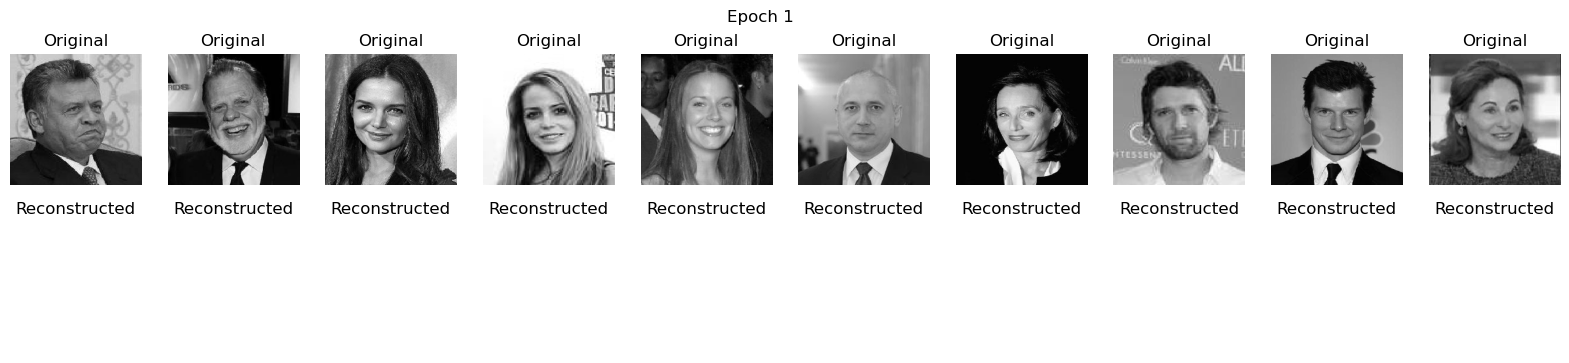

In [15]:
# Définir un callback personnalisé pour afficher la reconstruction toutes les 10 époques
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, test_data, display_loss_interval=20, display_recon_interval=50):
        super().__init__()
        self.model = model
        self.test_data = test_data
        self.display_loss_interval = display_loss_interval
        self.display_recon_interval = display_recon_interval

    def on_epoch_end(self, epoch, logs):
        if epoch % self.display_recon_interval == 0:
            reconstructions = self.model.predict(self.test_data, verbose = 0)
            self.display_reconstruction(epoch+1, self.test_data, reconstructions)
        if epoch % self.display_loss_interval == 0:
            pass #print(f"Epoch {epoch+1}, Loss: {logs['loss']:.4g}")


    def display_reconstruction(self, epoch, originals, reconstructions):
        n = 10  # Number of images to display
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # Display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(originals[i].reshape(224, 224), cmap='gray')
            plt.title("Original")
            plt.axis('off')
            
            # Display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(reconstructions[i].reshape(224, 224), cmap='gray')
            plt.title("Reconstructed")
            plt.axis('off')
        plt.suptitle(f'Epoch {epoch}')
        plt.savefig(f'Results/MSE/resnext+{epoch}.png')

ethnie = 'caucasians'
x_train = ethnies[ethnie][2] ; y_train = ethnies[ethnie][3]
x_val   = ethnies[ethnie][4] ; y_val   = ethnies[ethnie][5]
x_print = x_val.copy(); np.random.shuffle(x_print); x_print = x_print[:10]
# Entraîner le modèle avec le callback personnalisé
model.fit(x_train, x_train, epochs=2, shuffle=True, batch_size=8, callbacks=[CustomCallback(model, x_print)], verbose=1) #

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [ ]:
auto.save("auto_mae.hdf5")

In [ ]:
autoencodeur = load_model('auto_mse.hdf5')

126/126 [==============================] - 22s 171ms/step - loss: 0.0636

Epoch 106/201
126/126 [==============================] - 29s 231ms/step - loss: 0.0337 (MSE)

In [18]:
x_val_predict = model(x_val)

In [19]:
x_val_predict

<tf.Tensor: shape=(199, 224, 224, 1), dtype=float32, numpy=
array([[[[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        ...,

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]]],


       [[[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [na

In [11]:
x_train_predict = model(x_train[:31]).numpy()

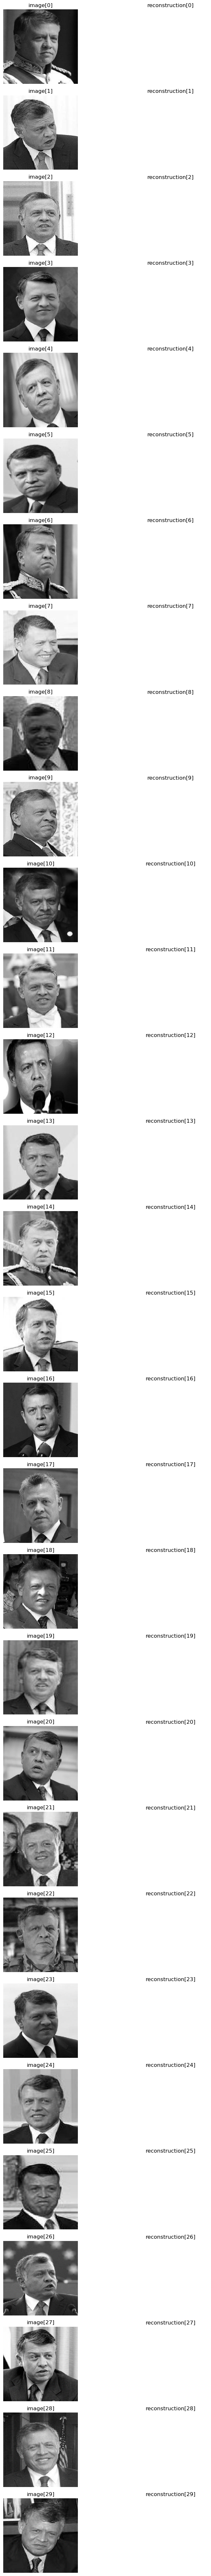

In [12]:
# Définir le nombre de lignes et de colonnes
rows = len(x_val)  # nombre d'images à afficher
cols = 2  # 2 colonnes, une pour l'image et une pour sa prédiction

fig, axes = plt.subplots(30, cols, figsize=(10, 80))

# Afficher les images dans la grille avec des légendes
for i in range(30):
    # Afficher l'image de x_val
    ax_val = axes[i, 0]
    ax_val.imshow(x_train[i], cmap='grey')
    ax_val.set_title(f'image[{i}]')
    ax_val.axis('off')
    
    # Afficher l'image de x_train
    ax_train = axes[i, 1]
    ax_train.imshow(x_train_predict[i], cmap='grey')
    ax_train.set_title(f'reconstruction[{i}]')
    ax_train.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def create_classifier(shape=(256, 256, 1), input_latent=512, len_vecteur=56):
    nbr_filters = [32, 64, 128, 256, 512, 1024, 2048]
    input_img = Input(shape=shape, name='input_image')
    x = Conv2D(16, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #encoder
    for filtres in nbr_filters:
        x = residual_block(x, filtres, 3, 2)
        print(x.shape)
    x = residual_block(x, input_latent, 3, 1)
    print(x.shape)
    x = Flatten()(x)

    # Espace latent
    latent_space_layer = Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = BatchNormalization(name='latent_space_layer_norm')(latent_space_layer)

    # Classification
    x_class = Dense(50, activation='relu', kernel_regularizer=l2(0.01))(latent_space_layer_norm)
    x_class = BatchNormalization()(x_class)
    x_class = Dropout(0.25)(x_class)
    x_class = Dense(25, activation='relu', kernel_regularizer=l2(0.01))(x_class)
    x_class = BatchNormalization()(x_class)
    x_class = Dropout(0.25)(x_class)
    x_class = Dense(len_vecteur, activation='softmax', name='classif')(x_class)

    model = Model(inputs=input_img, outputs=x_class)
    
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9, staircase=True)

    optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=CategoricalAccuracy())
    return model

In [ ]:
predictions = model_autoencoder.predict(x_val)
x_val_predict = predictions

In [ ]:
get_latent = tf.keras.Model(inputs=model_autoencoder.input, outputs=model_autoencoder.get_layer('latent_space_layer_norm').output)

In [ ]:
afro_americans_latent = get_latent.predict(x_val).reshape(x_val.shape[0], 512)
caucasian_latent = get_latent.predict(ethnies['caucasians'][-2]).reshape(ethnies['caucasians'][-2].shape[0], 512)
asians_latent = get_latent.predict(ethnies['asians'][-2]).reshape(ethnies['asians'][-2].shape[0], 512)

In [ ]:
# Définir le nombre de lignes et de colonnes
rows = len(x_val)  # nombre d'images à afficher
cols = 2  # 2 colonnes, une pour l'image et une pour sa prédiction

fig, axes = plt.subplots(30, cols, figsize=(10, 80))

# Afficher les images dans la grille avec des légendes
for i in range(30):
    # Afficher l'image de x_val
    ax_val = axes[i, 0]
    ax_val.imshow(x_val[i])
    ax_val.set_title(f'image[{i}]')
    ax_val.axis('off')
    
    # Afficher l'image de x_train
    ax_train = axes[i, 1]
    ax_train.imshow(x_val_predict[i])
    ax_train.set_title(f'reconstruction[{i}]')
    ax_train.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA


def pca(dico_latent, ethnie):
    scatters = []
    pca = PCA(n_components=2)
    plt.figure(figsize=(10, 8))
    for latent in dico_latent.keys():
        latent_pca = pca.fit_transform(dico_latent[latent][0])
        dico_latent[latent].append(latent_pca)  # ajout de latent_pca
        scatter = plt.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.5, label=latent)
        scatters.append(scatter)
    plt.legend(handles=scatters)
    plt.title(f'Projection ACP de l espace latent {ethnie}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    return dico_latent

dico_latent = {'afro_americans': [afro_americans_latent], 
               'caucasians': [caucasian_latent], 
               'asians': [asians_latent]}

dico_latent = pca(dico_latent, "afro_americans")

In [ ]:
def calculate_mean_dispersion(latent_representations):
    centroid = np.mean(latent_representations, axis=0)
    distance_squared = np.sum((latent_representations - centroid)**2, axis = 1)
    return np.mean(distance_squared)

def comparaison_dispersion(dico_latent):
    for ethnie in dico_latent.keys():
        dispersion = calculate_mean_dispersion(dico_latent[ethnie][1])
        print(f"Moyenne des dispersions des espaces latents pour les individus {ethnie} : {dispersion}")

comparaison_dispersion(dico_latent)

In [ ]:
def coef_bhattacharyya(P, Q):
    P = P / np.sum(P)
    Q = Q / np.sum(Q)
    return np.sum(np.sqrt(P * Q))

coef_bhattacharyya(dico_latent['caucasien'], dico_latent['afro_americans'])

def coef_B(dico_latent):
    ethnies = dico_latent.keys()
    for i in range(len(dico_latent.keys())):
        for j in range(i + 1, len(dico_latent)):
            ethnie1 = dico_latent[i]
            ethnie2 = dico_latent[j]
            coef = coef_bhattacharyya(dico_latent[ethnie1][0], dico_latent[ethnie2][0])
            print(f"Coef entre {ethnie1} et {ethnie2} : {coef}")

coef_B(dico_latent)